# Coursework Assignment 2: Measuring Sentence Similarity
The purpose of this file is to help you develop your model. You **DON'T** need to submit this file. In the end, you should submit
* A report, summarising all your findings and analyses.
* For task 1 (MLP-based model), submit two files: **test_mlp.ipynb** which includes the impelementation, and **best_mlp.state_dict**, which is the saved MLP weights.
* For task 2 (CNN- or RNN-based model), submit two files: **test_cnn.ipynb** (if you developed a RNN model, change cnn to rnn) which includes the impelementation, and **best_cnn.state_dict**, which is the saved CNN/RNN weights.
* For task 3 (additional models), similarly, submit the implementation as well as the saved weights.


## Load Data

In [4]:
# read data
import pandas as pd

train_data = pd.read_csv('cw2_train.csv')
dev_data = pd.read_csv('cw2_dev.csv')

train_data

,Unnamed: 0,Sent1,Sent2,SimScore
0,0,"U.S., EU Widen Sanctions On Russia","U.S., EU Boost Sanctions On Russia",1.00
1,1,The lawyers advised the judges .,The lawyers advised the judges behind the acto...,0.79
2,2,Man kills 4 in Calif. before police shoot him ...,Police: Gunman killed 6 in California shootings,0.40
3,3,Someone is playing a piano.,A man is playing a guitar.,0.24
4,4,In an E-mail statement to the Knoxville News S...,I am not giving any consideration to resignati...,0.80
...,...,...,...,...
11493,11493,A man is playing piano.,A man is laying on the ground.,0.15
11494,11494,"The doctors resigned , or the secretaries supp...",The doctors resigned .,0.50
11495,11495,The artist contacted the banker .,The banker contacted the artist by the student .,0.29
11496,11496,"While the professors arrived , the student wai...",The professors arrived .,0.61


## Load Pre-Trained Embeddings
In the sample code below, the Glove pre-trained embedding is used. Feel free to use other embeddings if you find it appropriate.

In [5]:
# load pre-trained glove embeddings
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np

word_vec_dim = 300
# specify the loaction of the downloaded glove file
link_to_embd = 'https://archive.org/download/glove.6B.50d-300d/glove.6B.300d.txt'

path_of_downloaded_files = "E:/RHUL/CW2-Handout/handout/glove.6B.300d.txt".format(word_vec_dim)
glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.6B.300d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)

oov_vec = np.random.rand(word_vec_dim)

def get_sent_word_vecs(word_vectors, sent_words):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    return np.array(vecs)

C:\Users\rusha\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
<ipython-input-5-126fad53f96a>:12: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


## Define the Sentence Encoder
Below, a simple model to create vector representations for sentences is provided. It first computes the average of the words embeddings, and then passes the average embedding to a fully-connected layer and applies a non-linear activation function to generate the final vector. You should develop more advanced models!

In [12]:
# define the baseline model
import numpy as np
import torch
import torch.nn as nn

class BaselineModel(nn.Module):
    def __init__(self, embd_dim):
        super(BaselineModel, self).__init__()
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)
        self.fully_connected_layer = nn.Linear(embd_dim, embd_dim)
        
    def forward(self, sent1_vecs, sent2_vecs):
        avg_embd1 = torch.mean(torch.FloatTensor(sent1_vecs), dim=0).unsqueeze(0)
        avg_embd2 = torch.mean(torch.FloatTensor(sent2_vecs), dim=0).unsqueeze(0)
        
        sent1_repr = self.leaky(self.fully_connected_layer(avg_embd1))
        sent2_repr = self.leaky(self.fully_connected_layer(avg_embd2))
        
        sent1_repr_1 = self.leaky(self.fully_connected_layer(avg_embd1))
        sent1_repr_1 = self.dropout(sent1_repr_1)
        sent2_repr_1 = self.leaky(self.fully_connected_layer(avg_embd2))
        sent2_repr_1 = self.dropout(sent2_repr_1)
        
        sent1_repr_2 = self.leaky(self.fully_connected_layer(avg_embd1))
        sent1_repr_2 = self.dropout(sent1_repr_2)
        sent2_repr_2 = self.leaky(self.fully_connected_layer(avg_embd2))
        sent2_repr_2 = self.dropout(sent2_repr_2)
        
        sent1_repr_3 = self.leaky(self.fully_connected_layer(avg_embd1))
        sent2_repr_3 = self.leaky(self.fully_connected_layer(avg_embd2))
        
        return sent1_repr_3, sent2_repr_3

## Training Pipeline
The function *train_model* below provides a general pipeline for training the sentence encoder model. You could re-use it for training the model you have developed.

In [13]:
from tqdm.notebook import tqdm

def train_model(train_data, n_epochs, lr, optimizer, loss_fnc, model):
    cos_sim = nn.CosineSimilarity()
    for epoch_i in tqdm(range(n_epochs)):
        ep_loss = []
        cnt = 0
        for i, entry in tqdm(train_data.sample(frac=1).iterrows()):
            cnt += 1
            sent1 = entry['Sent1']
            sent2 = entry['Sent2']
            sent1_embds = get_sent_word_vecs(word_vectors, sent1.split())
            sent2_embds = get_sent_word_vecs(word_vectors, sent2.split())

            # Step 1: Clear the gradients 
            optimizer.zero_grad()

            # Step 2: Compute the forward pass of the model
            sent1_repr, sent2_repr = model(sent1_embds, sent2_embds)
            pred_sim = cos_sim(sent1_repr, sent2_repr)
            true_sim = torch.FloatTensor([entry['SimScore']])

            # Step 3: Compute the loss value that we wish to optimize
            loss = loss_fnc(pred_sim, true_sim)
            ep_loss.append(loss.detach())

            # Step 4: Propagate the loss signal backward
            loss.backward()

            # Step 5: Trigger the optimizer to perform one update
            optimizer.step()

            if  cnt%1000 == 0:
                print('epoch {}, avg loss until step {}: {}'.format(epoch_i, cnt, np.mean(ep_loss)))

        print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
        

## Provide Hyper-Parameters and Start the Training
The hyper-parameters and optimizers provided below are just some examples. You should use appropriate strategy to find the hyper-parameters that you want to use!

In [14]:
model = BaselineModel(word_vec_dim)
loss_fnc = nn.MSELoss()

# hyper parameters
n_epochs = 4 
lr = 1e-2 

# init optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) 

train_model(train_data, n_epochs, lr, optimizer, loss_fnc, model)

epoch 0, avg loss until step 1000: 0.17281030118465424
epoch 0, avg loss until step 2000: 0.15705931186676025
epoch 0, avg loss until step 3000: 0.15313592553138733
epoch 0, avg loss until step 4000: 0.14774677157402039
epoch 0, avg loss until step 5000: 0.144443079829216
epoch 0, avg loss until step 6000: 0.14011049270629883
epoch 0, avg loss until step 7000: 0.1367943286895752
epoch 0, avg loss until step 8000: 0.13467946648597717
epoch 0, avg loss until step 9000: 0.1317826509475708
epoch 0, avg loss until step 10000: 0.13044840097427368
epoch 0, avg loss until step 11000: 0.1290140002965927


======epoch 0 loss====== 0.12782021


epoch 1, avg loss until step 1000: 0.11058720201253891
epoch 1, avg loss until step 2000: 0.10245262086391449
epoch 1, avg loss until step 3000: 0.10170764476060867
epoch 1, avg loss until step 4000: 0.10219619423151016
epoch 1, avg loss until step 5000: 0.10232393443584442
epoch 1, avg loss until step 6000: 0.10155695676803589
epoch 1, avg loss until step 7000: 0.09968837350606918
epoch 1, avg loss until step 8000: 0.09895970672369003
epoch 1, avg loss until step 9000: 0.09859517216682434
epoch 1, avg loss until step 10000: 0.09873271733522415
epoch 1, avg loss until step 11000: 0.09800665825605392


======epoch 1 loss====== 0.098207995


epoch 2, avg loss until step 1000: 0.08683335781097412
epoch 2, avg loss until step 2000: 0.08915097266435623
epoch 2, avg loss until step 3000: 0.08825340121984482
epoch 2, avg loss until step 4000: 0.08867310732603073
epoch 2, avg loss until step 5000: 0.08901476860046387
epoch 2, avg loss until step 6000: 0.0885675847530365
epoch 2, avg loss until step 7000: 0.08742988109588623
epoch 2, avg loss until step 8000: 0.08671735227108002
epoch 2, avg loss until step 9000: 0.08707444369792938
epoch 2, avg loss until step 10000: 0.08809768408536911
epoch 2, avg loss until step 11000: 0.0879080593585968


======epoch 2 loss====== 0.08780661


epoch 3, avg loss until step 1000: 0.0878792479634285
epoch 3, avg loss until step 2000: 0.0882926806807518
epoch 3, avg loss until step 3000: 0.08609800040721893
epoch 3, avg loss until step 4000: 0.0828108862042427
epoch 3, avg loss until step 5000: 0.0830763429403305
epoch 3, avg loss until step 6000: 0.08239112049341202
epoch 3, avg loss until step 7000: 0.08166351914405823
epoch 3, avg loss until step 8000: 0.08155874162912369
epoch 3, avg loss until step 9000: 0.08075597137212753
epoch 3, avg loss until step 10000: 0.08028236776590347
epoch 3, avg loss until step 11000: 0.0798366591334343


======epoch 3 loss====== 0.07959144



## Evaluate The Trained Model
The function *evaluate_trained_model* defined below tests the performance of a trained model on the dev_set. 

In [9]:
import matplotlib.pyplot as plt
def evaluate_trained_model(trained_model, dev_data):
    pred_scores = []
    true_scores = []
    cos_sim = nn.CosineSimilarity()
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        for i, entry in tqdm(dev_data.iterrows()):
            sent1 = entry['Sent1']
            sent2 = entry['Sent2']
            gold_score = entry['SimScore']
            sent1_embds = get_sent_word_vecs(word_vectors, sent1.split())
            sent2_embds = get_sent_word_vecs(word_vectors, sent2.split())
            sent1_repr, sent2_repr = trained_model(sent1_embds, sent2_embds)
            pred_sim = cos_sim(sent1_repr, sent2_repr)
        
            pred_scores.append(pred_sim)
            true_scores.append(gold_score)

    assert len(true_scores) == len(pred_scores)
    squared_errors = [np.square(ts-ps) for (ts, ps) in zip(true_scores, pred_scores)]
    print('MSE of the method on the dev set:', np.mean(squared_errors))

    # check the distribution (histo gram) of the squared errors
    plt.hist(squared_errors)


MSE of the method on the dev set: 0.08428164


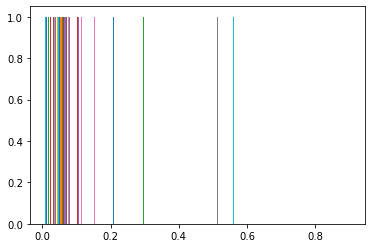

In [10]:
evaluate_trained_model(model, dev_data)

## Save trained model
The code below illustrates how to save the trained model. 

In [11]:
import pickle

info_to_save = {
    'model_state_dict': model.state_dict(),
    'oov_vec': oov_vec
}

with open('mlp_model.state_dict', 'wb') as ff:
    pickle.dump(info_to_save, ff)

In [2]:
pwd()

'E:\\RHUL\\CW2-Handout\\handout'